In [2]:
import pandas as pd
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

In [3]:
dataset = pd.read_csv('./datasets/final_dataset.csv')
dataset = dataset.drop(columns=['Unnamed: 0'])

In [3]:
dataset.columns

Index(['base_fee', 'timestamp', 'blocks', 'gas_limit', 'gas_used', 'legacy_tx',
       'sum_priority_fee_eth', 'tx', 'median_tip', 'q1_tip', 'q3_tip',
       'eth_price', 'date', 'fng_value', 'fng_classification', 'ethereum_tvl',
       'polygon_tvl', 'bsc_tvl', 'polygon_base_fee', 'polygon_blocks',
       'polygon_gas_limit', 'polygon_gas_used', 'polygon_legacy_tx',
       'polygon_sum_priority_fee_eth', 'polygon_tx', 'polygon_median_tip',
       'polygon_q1_tip', 'polygon_q3_tip', 'bsc_blocks', 'bsc_gas_limit',
       'bsc_gas_used', 'bsc_hourly_median_fee_tx', 'bsc_tx', 'bayc_floor_usd',
       'bayc_volume_usd', 'bayc_sales_count', 'cp_floor_usd', 'cp_volume_usd',
       'cp_sales_count', 'mayc_floor_usd', 'mayc_volume_usd',
       'mayc_sales_count', 'agp_floor_usd', 'agp_volume_usd',
       'agp_sales_count', 'csabc_floor_usd', 'csabc_volume_usd',
       'csabc_sales_count', 'fabc_floor_usd', 'fabc_volume_usd',
       'fabc_sales_count', 'azuki_floor_usd', 'azuki_volume_usd',
   

In [4]:
len(dataset.index)

8761

In [5]:
dataset = dataset.drop(columns=['timestamp','fng_classification','date'])

In [6]:
def reorder_dataset(dataset, n):
    
    ds = dataset.copy()
    columns = ds.columns
    for i in range (1,n+1):
        for column in columns:
            if column != 'median_tip':
                ds[column+'_'+str(i)] = np.nan

 

    for i in range (1,n+1):        
        for column in columns:
            if column != 'median_tip':
                ds[column+'_'+str(i)] = ds[column].shift(i)
            
    return ds

dataset_n1 = reorder_dataset(dataset,1)
dataset_n3 = reorder_dataset(dataset,3)
dataset_n5 = reorder_dataset(dataset,5)
dataset_n10 = reorder_dataset(dataset,10)
dataset_n24 = reorder_dataset(dataset,24)

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1533/3016634127.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[column+'_'+str(i)] = np.nan


In [7]:
columns = [x for x in dataset.columns if x != 'median_tip']

dataset_n1 = dataset_n1.drop(columns = columns)

dataset_n3 = dataset_n3.drop(columns = columns)

dataset_n5 = dataset_n5.drop(columns = columns)

dataset_n10 = dataset_n10.drop(columns = columns)

dataset_n24 = dataset_n24.drop(columns = columns)

In [8]:
#### Drop blocks without full history ####
dataset_n1 = dataset_n1.dropna()
dataset_n3 = dataset_n3.dropna()
dataset_n5 = dataset_n5.dropna()
dataset_n10 = dataset_n10.dropna()
dataset_n24 = dataset_n24.dropna()

In [9]:
alphas = [0, 0.03, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
random_grid = {'lasso__alpha': alphas,
}
print(random_grid)

best_metric = -100
best_N = -0

steps = [('scaler', StandardScaler()), ('lasso', Lasso())]

pipeline = Pipeline(steps)


N = [1,3,5,10,24]
lasso_results = []

for n in N:
    
    if n == 1:
        lasso_df = dataset_n1
    elif n ==3:
        lasso_df = dataset_n3
    elif n ==5:
        lasso_df = dataset_n5
    elif n ==10:
        lasso_df = dataset_n10
    elif n ==24:
        lasso_df = dataset_n24



    X = lasso_df.drop('median_tip', axis=1)
    y = lasso_df['median_tip']
    tscv = TimeSeriesSplit(n_splits=3, test_size=math.floor(len(lasso_df)*0.1), gap=n)
    lasso_bayes = BayesSearchCV(pipeline, random_grid, n_iter = 15, cv = tscv, verbose=0, random_state=42, n_jobs = -1, scoring="neg_mean_absolute_error")
    lasso_bayes.fit(X, y)
    print(n)
    print(lasso_bayes.best_estimator_)
    print(lasso_bayes.best_score_)
    if best_metric < lasso_bayes.best_score_:
        lasso = lasso_bayes.best_estimator_[1]
        best_metric = lasso_bayes.best_score_
        best_N = n
        lasso_results.append(lasso_bayes)
print("Best N and model: ", best_N, lasso)
print("Best metric: ", best_metric)
    

{'lasso__alpha': [0, 0.03, 0.05, 0.1, 0.3, 0.5, 0.8, 1]}


/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coor

1
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.03))])
-0.06020323813067726


/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **

3
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.03))])
-0.05693051589458048


/Users/fer/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast

5
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.03))])
-0.055967774742457586


/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coor

10
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.03))])
-0.055132142745717684


/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/fer/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **

24
Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.03))])
-0.05443348474636805
Best N and model:  24 Lasso(alpha=0.03)
Best metric:  -0.05443348474636805


In [10]:
if best_N == 1:
    training = dataset_n1
    lasso_final = lasso_results[0]
elif best_N ==3:
    training = dataset_n3
    lasso_final = lasso_results[1]
elif best_N ==5:
    training = dataset_n5
    lasso_final = lasso_results[2]
elif best_N ==10:
    training = dataset_n10
    lasso_final = lasso_results[3]
elif best_N ==24:
    training = dataset_n24
    lasso_final = lasso_results[4]

X = training.drop('median_tip', axis=1)

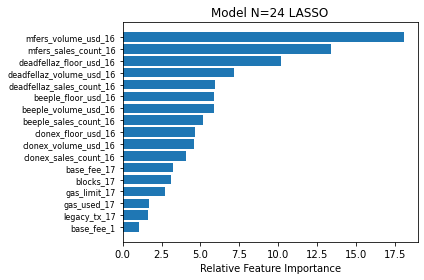

In [11]:
feature_importance = abs(lasso_final.best_estimator_[1].coef_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N='+str(best_N)+' LASSO')

plt.tight_layout()   
plt.show()

In [12]:
#### Real data validation ####
dataset_validation = pd.read_csv('./datasets/dataset_validation.csv')
dataset_validation = dataset_validation.drop(columns=['Unnamed: 0'])
dataset_validation

,base_fee,timestamp,blocks,gas_limit,gas_used,legacy_tx,sum_priority_fee_eth,tx,median_tip,q1_tip,...,mfers_sales_count,deadfellaz_floor_usd,deadfellaz_volume_usd,deadfellaz_sales_count,beeple_floor_usd,beeple_volume_usd,beeple_sales_count,clonex_floor_usd,clonex_volume_usd,clonex_sales_count
0,2.280913,2022-08-07 01:00:00,39,1169764903,688520770,887,1.663079,6582,0.529009,0.168829,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
1,15.432999,2022-08-07 02:00:00,237,7110027747,3880719039,7752,11.868786,45632,0.259681,0.143453,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
2,24.098700,2022-08-07 03:00:00,236,7080964616,3738681213,8183,15.676680,44685,0.213495,0.114983,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
3,20.704683,2022-08-07 04:00:00,259,7770467023,4057887078,10664,27.055056,51861,0.194821,0.118158,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
4,14.718397,2022-08-07 05:00:00,260,7799439368,4218450045,10480,11.841531,51113,0.168015,0.102764,...,24,1376.048000,15485.486578,10,28735.120000,0.0,0,13436.704000,104043.798720,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,72.111645,2022-09-01 02:00:00,262,7860700504,4377071552,6209,17.266260,45688,0.260117,0.149365,...,8,1040.413718,14744.637461,12,27915.435336,0.0,0,10886.242192,569498.519548,38
602,61.364488,2022-09-01 03:00:00,245,7350614227,3984931896,8060,17.113234,48005,0.204441,0.128885,...,8,1040.413718,14744.637461,12,27915.435336,0.0,0,10886.242192,569498.519548,38
603,45.194583,2022-09-01 04:00:00,241,7230584402,3824712180,8929,14.133103,40814,0.222156,0.109491,...,8,1040.413718,14744.637461,12,27915.435336,0.0,0,10886.242192,569498.519548,38
604,39.157729,2022-09-01 05:00:00,261,7831988695,4187495091,7087,15.891177,40512,0.241508,0.128553,...,8,1040.413718,14744.637461,12,27915.435336,0.0,0,10886.242192,569498.519548,38


In [13]:
dataset_validation = dataset_validation.drop(columns=['timestamp','fng_classification','date'])
columns = [x for x in dataset_validation.columns if x != 'median_tip']

n=best_N
dataset_validation = reorder_dataset(dataset_validation,n)
dataset_validation = dataset_validation.drop(columns = columns)

dataset_validation = dataset_validation.dropna()

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1533/3016634127.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[column+'_'+str(i)] = np.nan


In [14]:
##### LASSO Validation #####
y_validation = dataset_validation['median_tip']
X_validation = dataset_validation.drop('median_tip', axis=1)


y_val_pred_lasso = lasso_final.predict(X_validation)
y_val_pred_lasso = np.maximum(y_val_pred_lasso, 0.)

print('mean_absolute_error for validation LASSO: ', mean_absolute_error(y_validation, y_val_pred_lasso))

mean_absolute_error for validation LASSO:  0.037676769204019564


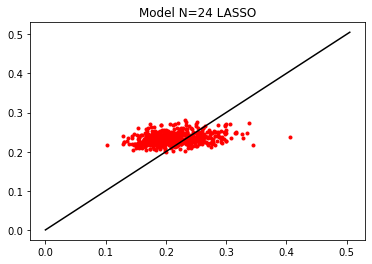

In [15]:
line=np.linspace(0,np.max(y_validation)+0.1,len(y_validation)) 

plt.plot(y_validation,y_val_pred_lasso,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N='+str(best_N)+' LASSO')


plt.show()

In [16]:
y_val_array = np.array(y_validation)
lower_values=0
for i in range(0,len(y_val_array)):
    if y_val_pred_lasso[i] <= y_val_array[i]:
        lower_values=lower_values+1

print("Amount of predicted min tip that wouldn't be enough to go through:" , lower_values)
print("Percetage of predicted min tip that wouldn't be enough to go through: ", (lower_values/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through: 156
Percetage of predicted min tip that wouldn't be enough to go through:  26.804123711340207 %


In [17]:
errors_validation = []
for i in range(0,len(y_val_array)):
    if abs(y_val_pred_lasso[i] - y_val_array[i]) <= 100:
        errors_validation.append(y_val_pred_lasso[i] - y_val_array[i])

erros_validation = np.array(errors_validation)

Text(0, 0.5, '# blocks')

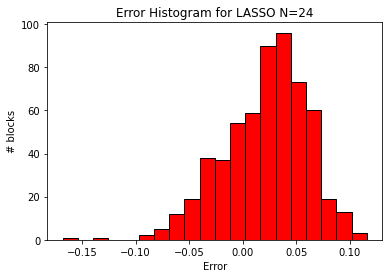

In [18]:
plt.hist(errors_validation, bins = 20, color = 'red', edgecolor = 'black')
#plt.xlim(-2,2)
plt.title('Error Histogram for LASSO N='+str(best_N)+'')
plt.xlabel('Error')
plt.ylabel('# blocks')

In [19]:
data = {'real_y': y_val_array, 'lasso_y': y_val_pred_lasso}
rf_results = pd.DataFrame(data).to_csv("lasso_results.csv")